## Heat Transfer from Knee to Ice Water

### Assumptions and declarations

#### Declarations

* $t$ is the time variable.
* $T_{w0}$ is the initial temperature of the ice water.
* $T_{sleeve}$ is the temperature of the plastic sleeve and starts at $25 C$
* $T_w$ as the temperature of water flowing throughout the device.

#### Assumptions
* We assume the water has initial temperature of $0 C$
* We assume that blood has same thermodynamic constants as water.
* We assume tissue of knee above blood is primarily skin layers and has same properties as skin.
* We assume that the fresh blood perfusing the tissue underneath the skin is constant at temperature $37 C$ and the skin starts at same temperature.
* We assume that the surface area of the capillary bed is the same as the surface area of the knee as a whole (i.e. that fresh blood is constantly being in contact with the tissue.)
* We assume that heat transfer from the knee skin and other portions of the device to the environment is negligible.
* We assume that the motor contributes negligible energy based on experiments run during a 20 minute period (the plastic casing prevent heat transfer from circuitry and the stirring of water will only contribute negligible amounts of energy).
* We assume that the sleeve material will start at the same temperature as the ice water.
* We assume that all individual items considered heat/cool at the same rate throughout the substance (i.e. one side of the sleeve pad is the same temperature as the other side of the sleeve pad).
* At least half of the water in the tank is in ice form





## Known Values
* The device sleeve is a low density polyethylene with thermal coefficient of $0.33 j/(m * K * s)$ at $25 C$
* The skin has a thermal conductivity of $0.31 j/(m * K *s)$
* The water has a thermal conductivity of $0.608 j / (m * k * s)$
* The sleeve of the device is of size $0.079 m^2$ ($10.85" x 11.34"$)



## Derivation of the Heat Transfer Equation from Water Through Plastic Sleeve

### Rate of thermal heat transfer:

$\\\dot Q = k * A * \Delta T / d$

$\\\dot Q = k * 0.079 m^2 * (T_w - T_{sleeve})$

### Heat Capacity of Plastic Sleeve:
$\\ \Delta Q = m c \Delta T$

$\\ \Delta Q = m c \Delta T$

$\\ \Delta Q = m c (T_f - T_i)$

$\\ \Delta Q + m c (T_i) =   m c T_f$

$\\ \Delta Q + m c (T_i) / (m c) = T_f$

$\\ \Delta Q = m 0.44 (T_{sleeve}(t_f) - T_{sleeve}(t_i))$

### Change in temp of plastic sleeve as function of time, assuming that $\dot Q$ is constant at instance
Assumption holds for small time periods when the T_{sleeve} has only changed slightly over time

$\\\dot Q \approx  \Delta Q / 1 sec $


$k * 0.079 * (T_w (t) - T_{sleeve}(t_i)) = m 0.44 (T_{sleeve}(t_f) - T_{sleeve}(t_i))$

Let's start with the maximum change in Q over time, which would be when the water is at temperature $0 C$ and the sleeve is at temperature $25 C$
$k * 0.079 * (0 - 25) = m 0.44 (T_{sleeve}(t_f) - y))$


In [2]:
# set up dependencies
import sys
sys.path.append("/home/saqibm128/miniconda3/envs/py37/lib/python3.7/site-packages")
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# define constants (we can change later if we were wrong)
K_ldpe = 0.33
K_water = 1200 #http://www.thermopedia.com/content/841/, pumping action of motor ensures that K_water is on higher side
A_sleeve = 0.079
d_sleeve = 0.003 / 2 # 3 mm
T_wi = 273 #Kelvin
T_sleevei = 298 #Kelvin
c_water = 4186 #http://hyperphysics.phy-astr.gsu.edu/hbase/thermo/spht.html
c_ldpe = 2100 #http://www.goodfellow.com/E/Polyethylene-Low-Density.html
d_skin = 0.02 #meters, https://www.histology.leeds.ac.uk/skin/skin_layers.php, https://www.cyh.com/HealthTopics/library/skin.pdf, we assume that muscle tissue underneath is skin is at least 0.0025 m in thickness as well
c_skin = 3.39 * 1000 #https://www.researchgate.net/publication/247609956_Specific_heat_capacities_of_human_and_animal_tissues
k_skin = 4 #https://www.ncbi.nlm.nih.gov/pubmed/9195861
T_body = 37 + 273 #kelvin
d_sleeve = 0.0005 #meters
m_sleeve = 0.010 # kg
knee_area = 102/ (100**2) #https://onlinelibrary.wiley.com/doi/pdf/10.1002/mrm.10097, 102 cm^2 / (1 m^2)
skin_density = 1.02 / 1000 * (100**3) #https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3699319/, 1.02 gm /cm^3 , 1020 kg/m^3
m_skin = skin_density * knee_area * d_skin

In [4]:
# Create functions which implements the thermal heat transfer equations and heat capacity equations
def heat_transfer_Q(k, A, d, deltaT):
    return k * A * deltaT / d
    
def heat_capacity_T_final(delta_Q, T_i, c, m):
    return ((m * c * T_i) + delta_Q) / (m * c)

In [5]:
import pandas as pd
from addict import Dict
# Create a quick and dirty definition for defining thermal relationships between objects, ThermItem (ThermodynamicItem)
class ThermItem(object):
    def __init__(self, T_i, c, k, m, d, name=None, forceTemp = None):
        '''
        T_i is initial temperature
        c is the specific heat capacity
        k is the heat transfer coefficient
        m is the total mass
        d is the distance of the object
        name is the name, in string
        forceTemp is a hack to model constantly fresh blood at 37 degrees celsius
        '''
        if c == 0:
            raise Exception()
        if m == 0:
            raise Exception()
        self.name = name
        self.t = 0 #current time unless if given in parameter
        self.T = pd.Series(index=[0]) # a series object to hold temperature data over time
        self.T[0] = T_i if forceTemp is None else forceTemp
        self.deltaQ = Dict() #holds heat transfers over time
        self.m = m
        self.k = k
        self.c = c
        self.d = d
        self.forceTemp = forceTemp
        self.relationships = []
        self.dontRecurse = False
        return None
    
    def getTemp(self, t=None):
        if self.forceTemp is not None:
            return self.forceTemp
        else:
            if t is None:
                t = self.t
            return self.T[t]
    
    def addRelationship(self, otherItem, a, directCall=True):
        # area exposed between two substances is not the same for every relationship with a single item. i.e. water
        #Connects two ThermodynamicItems (i.e. we will go ahead and change temp of one object with respect to another)
        relation = Dict()
        relation.item = otherItem
        relation.area = a
        self.relationships.append(relation)
        
        #we want to reflect that a relationship is two ways, but we only update if directCall is True to avoid infinite recursion
#         if directCall:
#             otherItem.addRelationship(self, a, False)
            
    def removeRelationship(self, otherItem, directCall=True):
        self.relationships.remove(otherItem)
#         if directCall:
#             otherItem.removeRelationship(self, False)
        
                
        
    def updateTemp(self, delta_t, t_curr = None):
        '''
        delta_t is change in time that we wish to do this. smaller delta_t is more accurate prediction but more computationally heavy
        t_curr is current time and is default the time of all objects
        '''
#         print(self.name)

    
        if t_curr is None:
            t_curr = self.t
        if t_curr + delta_t in self.T:
             return # we already updated for this, prevents infinite recursion
        if self.forceTemp is not None:
            self.T[t_curr + delta_t] = self.forceTemp
            return
#         if self.dontRecurse:
#             return
#         self.dontRecurse = True
        
        
        self.T[t_curr + delta_t] = self.getTemp()
        if t_curr not in self.deltaQ:
            self.deltaQ[t_curr] = 0
        #first we calculate the heat given from each item
        for relation in self.relationships:
            otherItem = relation.item
            contributedChangeInQ = heat_transfer_Q(self.k, relation.area, self.d, otherItem.getTemp() - self.getTemp()) * delta_t #per second
            self.deltaQ[t_curr] += contributedChangeInQ#can be overriden with a different value if deltaT is not same on each invocation!
            if t_curr not in otherItem.deltaQ:
                otherItem.deltaQ[t_curr] = 0
            otherItem.deltaQ[t_curr] -= contributedChangeInQ
            otherItem.updateTemp(delta_t) #go ahead and propagate update to other items as well!
            changeInQ = self.deltaQ[t_curr]
            if self.forceTemp is None: #don't try to update self.T if this is set
                #iteratively update temp for each item!
                self.T[t_curr + delta_t] = heat_capacity_T_final(changeInQ, self.T[t_curr + delta_t], self.c, self.m)
        self.dontRecurse = False
    def updateTime(self, delta_t):
        self.t = self.t + delta_t

class IceWater(ThermItem):
    def __init__(self, T_i, c, k, m, d, name=None, forceTemp = None, amountIce = 0):
        ThermItem.__init__(self, T_i, c, k, m, d, name=None, forceTemp = None)
        if c == 0:
            raise Exception()
        if m == 0:
            raise Exception()
        self.name = name
        self.t = 0 #current time unless if given in parameter
        self.T = pd.Series(index=[0]) # a series object to hold temperature data over time
        self.T[0] = T_i if forceTemp is None else forceTemp
        self.deltaQ = Dict() #holds heat transfers over time
        self.m = m
        self.k = k
        self.c = c
        self.d = d
        self.forceTemp = forceTemp
        self.relationships = []
        self.dontRecurse = False
        self.amountIce = amountIce
        return None
    
    
    #because of assumption that water is uniformly same temp, thermal rate is based off of other objects and their change in temp i.e. the plastics surrounding the water
    # we don't try to calculate the change in temp for the water using thermal energy transfer rate
    def updateTemp(self, delta_t, t_curr = None, forceRun =False):
        if t_curr is None:
            t_curr = self.t
        if t_curr + delta_t in self.T:
            return # we already updated for this, prevents infinite recursion 
        if not forceRun:
            return
        
        changeInQ = self.deltaQ[t_curr]
        
        #heat of formation of ice is 6.01 kj per mole or 6010 joules / 18.04 g * 1000 g /kg
        
        hfInKg =  6010/18.04 * 1000
        if self.amountIce > 0:
            if self.amountIce * hfInKg < changeInQ: # we can melt the ice and start to increase the water temp!
                self.amountIce = 0
                changeInQ -= self.amountIce * hfInKg
            else:
                self.amountIce -= changeInQ / hfInKg
                changeInQ = 0
    
        
        self.T[t_curr + delta_t] = heat_capacity_T_final(changeInQ, self.getTemp(), self.c, self.m)
        

In [7]:
kneeBlood = ThermItem(m=None, c=None, k=None, d=None, T_i=T_body, name="kneeBlood", forceTemp=T_body) #coefficients don't matter since this has forceTemp
air = ThermItem(m=None, c=None, k=None, d=None, T_i=298, name="air", forceTemp=298)
kneeSkinTissue = ThermItem(name="kneeSkinTissue", d = d_skin, m = m_skin, c = c_skin, k=k_skin, T_i=T_body)
sleeve = ThermItem(name="knee pad", d = d_sleeve, m = 0.05, c=c_ldpe, k=K_ldpe, T_i=298)
iceWater = IceWater(name="ice water", k=None, d=None, m = 4.75, c=c_water, T_i =T_wi, amountIce = 0)

# rubberHose = ThermItem(m=, )

allComps = [kneeBlood, kneeSkinTissue, sleeve, iceWater]

kneeSkinTissue.addRelationship(kneeBlood, knee_area)
kneeSkinTissue.addRelationship(sleeve, A_sleeve)
sleeve.addRelationship(iceWater, A_sleeve)

delta_t = 2
for i in range(5000):
    kneeSkinTissue.updateTemp(delta_t)
    iceWater.updateTemp(delta_t, forceRun=True)
    for comp in allComps:
        comp.updateTime(delta_t)

# plt.plot(kneeSkinTissue.T)



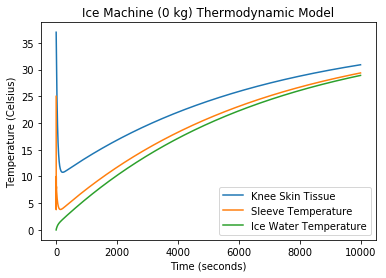

In [41]:
plt.title("Ice Machine (0 kg) Thermodynamic Model")
plt.plot(kneeSkinTissue.T - 273, label="Knee Skin Tissue")
plt.plot(sleeve.T - 273, label="Sleeve Temperature")
plt.plot(iceWater.T - 273, label="Ice Water Temperature")
plt.xlabel("Time (seconds)")
plt.ylabel("Temperature (Celsius)")
leg = plt.legend()
plt.savefig("/mnt/c/Users/sawer/src/2310Model/ice_0_kg.png", dpi=600)
plt.show()

In [20]:
kneeBlood_half = ThermItem(m=None, c=None, k=None, d=None, T_i=T_body, name="kneeBlood", forceTemp=T_body) #coefficients don't matter since this has forceTemp
air_half = ThermItem(m=None, c=None, k=None, d=None, T_i=298, name="air", forceTemp=298)
kneeSkinTissue_half = ThermItem(name="kneeSkinTissue", d = d_skin, m = m_skin, c = c_skin, k=k_skin, T_i=T_body)
sleeve_half = ThermItem(name="knee pad", d = d_sleeve, m = 0.05, c=c_ldpe, k=K_ldpe, T_i=298)
iceWater_half = IceWater(name="ice water", k=None, d=None, m = 4.75, c=c_water, T_i =T_wi, amountIce = 0.5)

# rubberHose = ThermItem(m=, )

allComps = [kneeBlood_half, kneeSkinTissue_half, sleeve_half, iceWater_half]

kneeSkinTissue_half.addRelationship(kneeBlood_half, knee_area)
kneeSkinTissue_half.addRelationship(sleeve_half, A_sleeve)
sleeve_half.addRelationship(iceWater_half, A_sleeve)

delta_t = 2
for i in range(5000):
    kneeSkinTissue_half.updateTemp(delta_t)
    iceWater_half.updateTemp(delta_t, forceRun=True)
    for comp in allComps:
        comp.updateTime(delta_t)

# plt.plot(kneeSkinTissue.T)



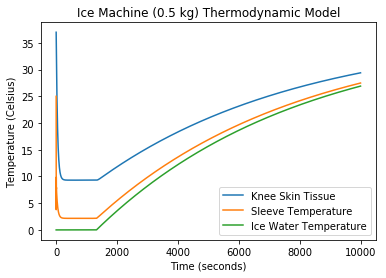

In [42]:
plt.title("Ice Machine (0.5 kg) Thermodynamic Model")
plt.plot(kneeSkinTissue_half.T - 273, label="Knee Skin Tissue")
plt.plot(sleeve_half.T - 273, label="Sleeve Temperature")
plt.plot(iceWater_half.T - 273, label="Ice Water Temperature")
plt.xlabel("Time (seconds)")
plt.ylabel("Temperature (Celsius)")
leg = plt.legend()
plt.savefig("/mnt/c/Users/sawer/src/2310Model/ice_0_5_kg.png", dpi=600)
plt.show()

In [24]:
kneeBlood_three = ThermItem(m=None, c=None, k=None, d=None, T_i=T_body, name="kneeBlood", forceTemp=T_body) #coefficients don't matter since this has forceTemp
air_three = ThermItem(m=None, c=None, k=None, d=None, T_i=298, name="air", forceTemp=298)
kneeSkinTissue_three = ThermItem(name="kneeSkinTissue", d = d_skin, m = m_skin, c = c_skin, k=k_skin, T_i=T_body)
sleeve_three = ThermItem(name="knee pad", d = d_sleeve, m = 0.05, c=c_ldpe, k=K_ldpe, T_i=298)
iceWater_three = IceWater(name="ice water", k=None, d=None, m = 4.75, c=c_water, T_i =T_wi, amountIce = 3)

# rubberHose = ThermItem(m=, )

allComps = [kneeBlood_three, kneeSkinTissue_three, sleeve_three, iceWater_three]

kneeSkinTissue_three.addRelationship(kneeBlood_three, knee_area)
kneeSkinTissue_three.addRelationship(sleeve_three, A_sleeve)
sleeve_three.addRelationship(iceWater_three, A_sleeve)

delta_t = .5
for i in range(20000):
    kneeSkinTissue_three.updateTemp(delta_t)
    iceWater_three.updateTemp(delta_t, forceRun=True)
    for comp in allComps:
        comp.updateTime(delta_t)

# plt.plot(kneeSkinTissue.T)



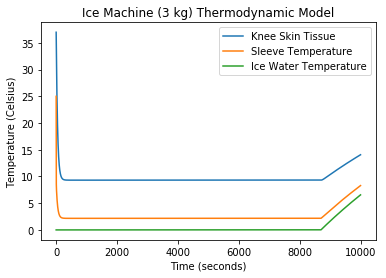

In [43]:
plt.title("Ice Machine (3 kg) Thermodynamic Model")
plt.plot(kneeSkinTissue_three.T - 273, label="Knee Skin Tissue")
plt.plot(sleeve_three.T - 273, label="Sleeve Temperature")
plt.plot(iceWater_three.T - 273, label="Ice Water Temperature")
plt.xlabel("Time (seconds)")
plt.ylabel("Temperature (Celsius)")
leg = plt.legend()
plt.savefig("/mnt/c/Users/sawer/src/2310Model/ice_3_kg.png", dpi=600)
plt.show()

In [25]:
kneeBlood_grant = ThermItem(m=None, c=None, k=None, d=None, T_i=T_body, name="kneeBlood", forceTemp=T_body) #coefficients don't matter since this has forceTemp
air_grant = ThermItem(m=None, c=None, k=None, d=None, T_i=298, name="air", forceTemp=298)
kneeSkinTissue_grant = ThermItem(name="kneeSkinTissue", d = d_skin, m = m_skin, c = c_skin, k=k_skin, T_i=31.9)
sleeve_grant = ThermItem(name="knee pad", d = d_sleeve, m = 0.05, c=c_ldpe, k=K_ldpe, T_i=24 + 273)
iceWater_grant = IceWater(name="ice water", k=None, d=None, m = 4.75, c=c_water, T_i =T_wi, amountIce = 2.3)

# rubberHose = ThermItem(m=, )

allComps = [kneeBlood_grant, kneeSkinTissue_grant, sleeve_grant, iceWater_grant]

kneeSkinTissue_grant.addRelationship(kneeBlood_grant, knee_area)
kneeSkinTissue_grant.addRelationship(sleeve_grant, A_sleeve)
sleeve_grant.addRelationship(iceWater_grant, A_sleeve)

delta_t = .5
for i in range(20000):
    kneeSkinTissue_grant.updateTemp(delta_t)
    iceWater_grant.updateTemp(delta_t, forceRun=True)
    for comp in allComps:
        comp.updateTime(delta_t)

# plt.plot(kneeSkinTissue.T)

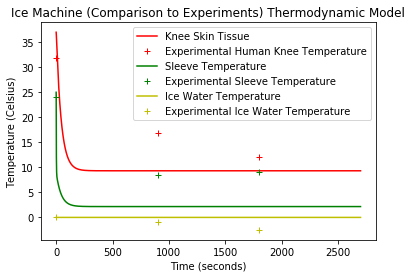

In [44]:
plt.title("Ice Machine (Comparison to Experiments) Thermodynamic Model")
plt.plot(kneeSkinTissue_three.T[0:60*45] - 273, 'r', label="Knee Skin Tissue")
plt.plot([0, 15 * 60, 30*60],[31.9, 16.8, 12], 'r+', label = "Experimental Human Knee Temperature")
plt.plot(sleeve_three.T[0:60*45] - 273, 'g', label="Sleeve Temperature")
plt.plot([0, 15 * 60, 30*60],[24, 8.5, 9], 'g+', label = "Experimental Sleeve Temperature")
plt.plot(iceWater_three.T[0:60*45] - 273, 'y', label="Ice Water Temperature")
plt.plot([0, 15*60, 30*60], [0, -.9, -2.5], 'y+', label="Experimental Ice Water Temperature")
plt.xlabel("Time (seconds)")
plt.ylabel("Temperature (Celsius)")
leg = plt.legend()
plt.savefig("/mnt/c/Users/sawer/src/2310Model/ice_experimental_kg.png", dpi=600)
plt.show()